In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os
import yaml

from PIL import Image



In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!kaggle datasets download -d thepbordin/indoor-object-detection

!unzip "/content/indoor-object-detection.zip"

 97% 356M/367M [00:04<00:00, 118MB/s]
100% 367M/367M [00:04<00:00, 84.1MB/s]
Archive:  /content/indoor-object-detection.zip
  inflating: data.yaml               
  inflating: test/images/1003.png    
  inflating: test/images/1014.png    
  inflating: test/images/1015.png    
  inflating: test/images/1020.png    
  inflating: test/images/1021.png    
  inflating: test/images/1023.png    
  inflating: test/images/1026.png    
  inflating: test/images/1027.png    
  inflating: test/images/1028.png    
  inflating: test/images/1029.png    
  inflating: test/images/1032.png    
  inflating: test/images/1034.png    
  inflating: test/images/1040.png    
  inflating: test/images/1043.png    
  inflating: test/images/1045.png    
  inflating: test/images/1047.png    
  inflating: test/images/1048.png    
  inflating: test/images/1052.png    
  inflating: test/images/1054.png    
  inflating: test/images/1055.png    
  inflating: test/images/1058.png    
  inflating: test/images/1065.png    
  

In [3]:
root_dir="/kaggle/input/indoor-object-detection"
train_imgs_dir="/content/train/images"
valid_imgs_dir="/content/test/images"
test_imgs_dir="/content/test/images"

train_labels_dir="/content/train/labels"
valid_labels_dir="/content/test/labels"
test_labels_dir="/content/test/labels"

In [4]:
names={0:"door",1:"cabinetDoor",2:"refrigeratorDoor",3:"window",4:"chair",5:"table",
       6:"cabinet",7:"couch",8:"openedDoor",9:"pole"}
COLORS=np.random.uniform(0,255,(10,3))

In [5]:
def show_bbox(img_name,img_dir,label_dir,axis):
    img_path=os.path.join(img_dir,img_name)
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,_=img.shape
    img=img.copy()

    try:
        label_path=os.path.join(label_dir,img_name[:-4]+".txt")
        label=pd.read_csv(label_path,sep=" ",header=None).values
        classes=label[:,0]
        boxes=label[:,1:]

        for i,box in enumerate(boxes):
            cls_id=int(classes[i])
            text=names[cls_id]
            color=COLORS[cls_id]
            xmin=int((box[0]-box[2]/2)*w)
            ymin=int((box[1]-box[3]/2)*h)
            xmax=int((box[0]+box[2]/2)*w)
            ymax=int((box[1]+box[3]/2)*h)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color,3)
            y=ymin-10 if ymin-10>10 else ymin+20
            cv2.putText(img,text,(xmin,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,color,3)
    except:
        pass

    axis.imshow(img)
    axis.axis("off")

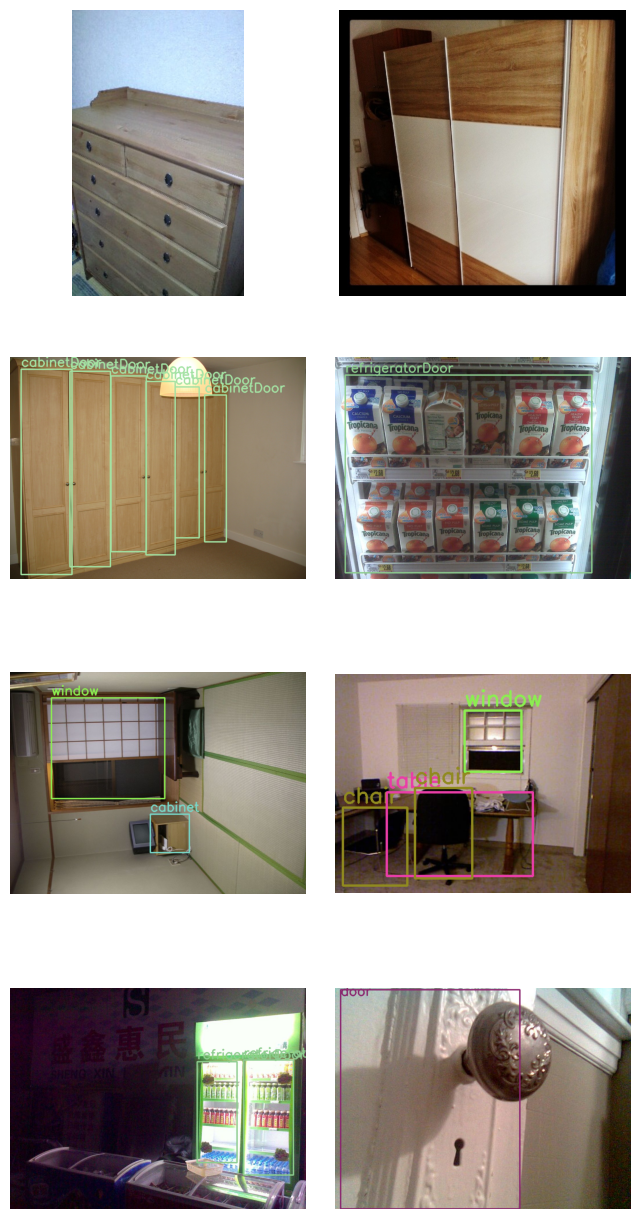

In [6]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()


train_img_list=sorted(os.listdir(train_imgs_dir))
img_name_list=np.random.choice(train_img_list,8)


for i,img_name in enumerate(img_name_list):
    show_bbox(img_name,train_imgs_dir,train_labels_dir,ax[i])

plt.savefig("1.png")

In [7]:
num_files_to_load = 100

train_image_files = os.listdir(train_imgs_dir)[:num_files_to_load]
valid_image_files = os.listdir(valid_imgs_dir)[:num_files_to_load]
test_image_files = os.listdir(test_imgs_dir)[:num_files_to_load]

common_width = 1024

train_images = np.empty((0, 1024, 1024, 3), dtype=np.uint8)
valid_images = np.empty((0, 1024, 1024, 3), dtype=np.uint8)
test_images = np.empty((0, 1024, 1024, 3), dtype=np.uint8)


In [8]:
batch_size = 100;

for image_file in train_image_files:
    image_path = os.path.join(train_imgs_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (1024, 1024))
    image = np.expand_dims(image, axis=0)
    train_images = np.append(train_images, image, axis=0)

for image_file in valid_image_files:
    image_path = os.path.join(valid_imgs_dir,image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (1024, 1024))
    image = np.expand_dims(image, axis=0)
    valid_images = np.append(valid_images, image, axis=0)

for image_file in test_image_files:
    image_path = os.path.join(test_imgs_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (1024, 1024))
    image = np.expand_dims(image, axis=0)
    test_images = np.append(test_images, image, axis=0)

train_images = np.array(train_images)
valid_images = np.array(valid_images)
test_images = np.array(test_images)

train_images[0].shape


(1024, 1024, 3)

In [47]:
import os

train_labels_files = os.listdir(train_labels_dir)[:num_files_to_load]
valid_labels_files = os.listdir(valid_labels_dir)[:num_files_to_load]
test_labels_files = os.listdir(test_labels_dir)[:num_files_to_load]

train_labels = []
valid_labels = []
test_labels = []

dictlabels = {}

'''
train_labels = {
    'class_ids': np.array([0, 1, 8, 1]),
    'bounding_boxes': np.array([[0.374023, 0.854818, 0.138672, 0.230469],
                                [0.939941, 0.597005, 0.118164, 0.782552],
                                [0.826118, 0.582643, 0.347764, 0.803151],
                                [0.503418, 0.822266, 0.100586, 0.240885]])
}
'''

train_labels = []
class_ids = []
dim_vals = []
for image_label in train_labels_files:
    image_label_path = os.path.join(train_labels_dir, os.path.splitext(image_label)[0] + ".txt")
    with open(image_label_path, 'r') as file:
        labels = file.readlines()
        lab= []
        dim = []
        for i in labels:
          i = i.split(" ")
          lab.append(i[0])
          dim.append([i[1], i[2], i[3], i[4]])
        # train_labels.append({ 'class_ids' : np.array(lab) , 'bounding_boxes': np.array(dim)})
        class_ids.append(np.array(lab))
        dim_vals.append(np.array(dim))


for valid_label in valid_labels_files:
    valid_label_path = os.path.join(valid_labels_dir, os.path.splitext(valid_label)[0] + ".txt")
    with open(valid_label_path, 'r') as file:
        labels = file.readlines()
        lab= []
        dim = []
        for i in labels:
            i = i.split(" ")
            lab.append(i[0])
            dim.append([i[1], i[2], i[3], i[4]])
        valid_labels.append({'class_ids' : np.array(lab) , 'bounding_boxes': np.array(dim)})

for image_label in test_labels_files:
    image_label_path = os.path.join(test_labels_dir, os.path.splitext(image_label)[0] + ".txt")
    with open(image_label_path, 'r') as file:
        labels = file.readlines()
        lab= []
        dim = []
        for i in labels:
            lab = i.split(" ")
            lab.append(i[0])
            dim.append([i[1], i[2], i[3], i[4]])
        test_labels.append({'class_ids' : np.array(lab) , 'bounding_boxes': np.array(dim)})


print(train_labels)

class_ids = np.array(class_ids)
dim_vals = np.array(dim_vals)

# train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)



[]


<ipython-input-47-04da51057dee>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  class_ids = np.array(class_ids)
<ipython-input-47-04da51057dee>:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dim_vals = np.array(dim_vals)


In [ ]:
def buildCnnModel(input_shape, num_classes):
    backbone = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
    ])


    rpn = keras.Sequential([
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(4, (1, 1), activation='linear', name='rpn_bbox_regression'),
        keras.layers.Conv2D(2, (1, 1), activation='softmax', name='rpn_objectness')
    ])

    classification_head = keras.layers.Dense(10, activation='softmax', name='classification')
    regression_head = keras.layers.Dense(3, activation='linear', name='bbox_regression')

    inputs = keras.layers.Input(shape=input_shape)
    features = backbone(inputs)
    rpn_output = rpn(features)
    classification = classification_head(features)
    regression = regression_head(features)

    model = keras.Model(inputs=inputs, outputs=[classification, regression])


    return model

# def buildCnnModel(input_shape, num_classes):
#     backbone = keras.Sequential([
#         keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
#         keras.layers.MaxPooling2D((2, 2)),
#         keras.layers.Conv2D(128, (3, 3), activation='relu'),
#         keras.layers.MaxPooling2D((2, 2)),
#         keras.layers.Flatten(),
#         keras.layers.Dense(256, activation='relu'),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     # classification_head = keras.layers.Dense(num_classes, activation='softmax', name='classification')
#     # regression_head = keras.layers.Dense(3, activation='linear', name='bbox_regression')

#     # inputs = keras.layers.Input(shape=input_shape)
#     # features = backbone(inputs)
#     # classification = classification_head(features)
#     # regression = regression_head(features)

#     # model = keras.Model(inputs=inputs, outputs=[classification, regression])

#     return backbone

input_shape = (1024, 1024, 3)
num_classes = 10




cnn_model = buildCnnModel(input_shape, num_classes)

cnn_model.summary()

single_image = train_images[0]  # Replace this with your actual image data

# Create a batch of 100 images by repeating the single image
batch_size = 100
batch_images = np.repeat(np.expand_dims(single_image, axis=0), batch_size, axis=0)
print(batch_images.shape)

prediction = cnn_model.predict(batch_images)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 128)        75648     ['input_1[0][0]']             
                                                                                                  
 classification (Dense)      (None, 256, 256, 10)         1290      ['sequential[0][0]']          
                                                                                                  
 bbox_regression (Dense)     (None, 256, 256, 3)          387       ['sequential[0][0]']          
                                                                                              

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
BATCH_SIZE = 64
EPOCHS = 5



cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

ValueError: ignored